# Face Recognition using Principal Component Analysis 

In the language of information theory, we want to extract the relevant information in a face image, encode it as effectively as possible, and compare one face encoding with a database of models encoded similarly. A simple approach to extracting the information contained in an image of a face is to somehow capture the variation in a collection of face images, independent of any judgment of features, and use this information to encode and compare individual face images. Hence in PCA we aim to find the direction where the variance is maximum. 

Author: Ajay Biswas

Roll no.: 220CS2184

M.Tech. Information Security, NIT Rourkela.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from matplotlib import image
import os

### Face Mean Calculation (Row-wise mean)

>$M_i = \Sigma_{i=1}^{mn}\Sigma_{j=1}^p FaceDB(i,j)$

In [2]:
def mean_face(Face):
    mn,p = Face.shape
    M = np.zeros((mn,1))
    for i in range(mn):
        for j in range(p):
            M[i] += Face[i][j]
        M[i] /= p
    return M

### Surrogate Covariance 

>$C(p,p) = \Sigma_{z=1}^{mn}\Sigma_{y=1}^mn\Sigma_{i=1}^p(\Delta(z,i) - M_y)\times(\Delta(z,i)-M_z).T$

In [3]:
def surrogate_cov(X):
# Returns covariance of X
    rows,cols = X.shape 
    cov = np.zeros((cols,cols))
     
    # Covariances        
    for z in range(cols):
        for y in range(cols):
                cov[z][y] = np.dot(X[:,y].T,X[:,z])/rows                
    return cov 

### Loading Images

In [4]:
# load images of size 112,92 

train_image_load = []
test_image_load = []

total_person = 40
train_size = 6
test_size = 4

# tracks train set and test set

for i in range(1,total_person+1):
    j = 1
    arr = os.listdir('s'+str(i)+'/')
    for _ in arr:
        if(j <= train_size):
            train_image_load.append((image.imread('s'+str(i)+'/'+_)).flatten())
        else:
            test_image_load.append((image.imread('s'+str(i)+'/'+_)).flatten())
        j+=1
 

## Training Phase

### Step 1: Generate the face database

In [5]:
# step 1 generate face dataset (mn*p)
# 60% for training (6 images/folder)
Face_Db = np.array(train_image_load).T  
mn,p = Face_Db.shape
print(Face_Db.shape)

(10304, 240)


### Step 2: Mean Calculation (M)

In [6]:
# step 2 calculate mean (mn*1)

M = mean_face(Face_Db)
print(M)

[[85.3375    ]
 [85.35416667]
 [85.7375    ]
 ...
 [73.32916667]
 [73.73333333]
 [73.20416667]]


### Step 3: Mean 0 ($\Delta$)

In [7]:
# step 3 mean 0
delta = np.zeros((Face_Db.shape))
for i in range(mn):
    for j in range(p):
        delta[i][j] = Face_Db[i][j] - M[i]
        

### Step 4: Calculate Co-Variance of the Mean aligned faces ($\Delta$)

In [8]:
# step 4 surrogate covariance calculation
cov = surrogate_cov(delta)   
print(cov.shape)

(240, 240)


### Step 5:  Eigenvalue and Eigenvector decomposition: 

In [9]:
# step 5 eigen values and eigen vectors (sorted decreasing order) of cov
eigenValues, eigenVectors = np.linalg.eig(cov)
idx = eigenValues.argsort()[::-1]   
eig_val = eigenValues[idx]
eig_vec = eigenVectors[:,idx]

### Step 6: Find Best Direction and generate Feature Vector ($\Psi$)

In [10]:
# setting k
k = 50

a1 = eig_vec[:,1]
PC1_mat = np.dot(a1.T,Face_Db.T)
psi = eig_vec[:,0:k]
print(psi.shape)

(240, 50)


### Step 7: Generating Eigenfaces ($\Phi$)

>$(\Phi)_{k*mn} = (\Psi)_{k*p}^t * (\Delta)_{p*mn}^t$

In [11]:
# step 7 Generate Eigen Faces
phi = np.dot(psi.T,delta.T)
print("Eigen Faces Dimensions")
print(phi.shape)

Eigen Faces Dimensions
(50, 10304)


### Step 8: Signature of Each Face ($\omega$)

>$(\omega)_{k*i} = (\Phi)_{k*mn} * (\Delta)_{mn*i}$

Where $i \in {1,2,3,...,p}$

In [12]:
# step 8 Generate Signature
omega = np.dot(phi,delta)
print("Signature dimensions")
print(omega.shape)

Signature dimensions
(50, 240)


### PC1

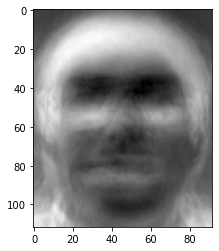

In [13]:
img1 = PC1_mat.reshape((112, 92))
plt.imshow(img1, cmap='gray')
plt.show()

## Testing Phase

### Euclidean Distance

In [14]:
def euclidean_distance(p1,p2):
    distance = pow(sum([(a - b) ** 2 for a, b in zip(p1, p2)]),0.5)
    return distance 

### Step 1: Make an image (I) a column vector (Imposter Image)

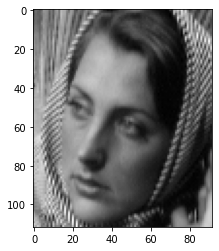

In [15]:
img = image.imread('barbara.pgm')
plt.imshow(img[:,:,0], cmap='gray')
Iota_1 = (np.array(img)[:,:,0]).flatten()

### Step 2: Do mean zero

> $(I)_{mn*1}^2 = (I)_{mn*1}^1 - (M)_{mn*1}$

In [16]:
# step 2 mean 0 for testing
Iota_2 = np.zeros(len(Iota_1))
for i in range(len(Iota_1)):
    Iota_2[i] = Iota_1[i] - M[i]

print(Iota_2.shape)

(10304,)


### Step 3: Project the mean aligned face to eigenfaces

>$(\Omega)_{k*1} = (\Phi)_{k*mn} * (I)_{mn*1}$

In [17]:
Omega = np.dot(phi,Iota_2)

print(Omega.shape)

(50,)


### Step 4: Test projected face

In [18]:
# column wise minimum distance calculation
# transposing omega for simplicity (passing vector as array)
omega_T = omega.T

# minimum distance
min_dist = 999999999

j = 0

# calculating distace from all faces
for sign in omega_T:
    distance = euclidean_distance(Omega,sign)
    if(distance < min_dist):
        min_dist = distance
        label = j
    j+=1

print("Predicted class")
print((label//train_size) + 1)

Predicted class
22


### Accuracy Rate

In [19]:
def accuracy_rate(X,Y):
    count = 0
    for i in range(len(X)):
        if(X[i] == Y[i]):
            count = count + 1
    return (count/len(X))*100

### Repeat testing for entire test set by varying k and generate accuracy curve

In [20]:
# true labels
trueLabels = np.arange(0,test_size*total_person)
trueLabels = (trueLabels//test_size)

Test_Face_Db = np.array(test_image_load).T 
# step 2 mean 0 for testing
Iota_2 = np.zeros((Test_Face_Db.shape))
mn,q = Test_Face_Db.shape

for i in range(mn):
    for j in range(q):
        Iota_2[i][j] = Test_Face_Db[i][j] - M[i]
        
Omega = np.dot(phi,Iota_2)

# column wise minimum distance calculation
# transposing both of them will makes things easier
Omega_T = Omega.T
omega_T = omega.T

accuracy_curve = []

for k in range(1,51):

    # minimum distance
    min_dist = 999999999

    distances = [0]*q
    classes = [0]*q

    i = 0
    for sign_test in Omega_T:
        j = 0
        for sign_train in omega_T:
            dist = euclidean_distance(sign_test[0:k],sign_train[0:k])
            if(dist < min_dist):
                min_dist = dist
                label = j
            j+=1

        distances[i] = min_dist
        classes[i] = (label//train_size) # each person testset contains 4 images
        i+=1
        min_dist = 99999999

    accuracy = accuracy_rate(trueLabels,classes)
    accuracy_curve.append(accuracy)

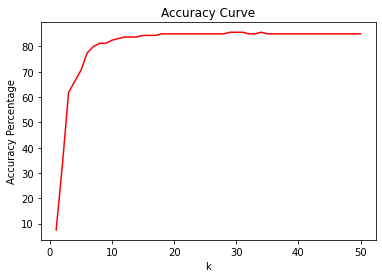

In [21]:
plt.plot(np.arange(1,51), accuracy_curve, color ="red")  
plt.title("Accuracy Curve")  
plt.xlabel("k")  
plt.ylabel("Accuracy Percentage") 
plt.show()